# ATM Cash Demand Forecasting
* Goal: Predict how much cash each ATM will need over different time horizons
* Objective: To build a time series model that accurately predicts the Cash_Demand_Next_Day for each ATM, enabling optimized cash replenishment, reduced operational costs, and minimized cash-out situations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


In [2]:
df=pd.read_csv('/kaggle/input/atm-cash-demand-forecasting-and-management/atm_cash_management_dataset.csv')

## 1.Data Understanding

In [3]:
# Basic inspection
df.info()
print(df.describe())
print('missing data\n',df.isnull().sum()) # Check for missing values
df=df.drop_duplicates() #remove duplicates 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5658 entries, 0 to 5657
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ATM_ID                   5658 non-null   object
 1   Date                     5658 non-null   object
 2   Day_of_Week              5658 non-null   object
 3   Time_of_Day              5658 non-null   object
 4   Total_Withdrawals        5658 non-null   int64 
 5   Total_Deposits           5658 non-null   int64 
 6   Location_Type            5658 non-null   object
 7   Holiday_Flag             5658 non-null   int64 
 8   Special_Event_Flag       5658 non-null   int64 
 9   Previous_Day_Cash_Level  5658 non-null   int64 
 10  Weather_Condition        5658 non-null   object
 11  Nearby_Competitor_ATMs   5658 non-null   int64 
 12  Cash_Demand_Next_Day     5658 non-null   int64 
dtypes: int64(7), object(6)
memory usage: 574.8+ KB
       Total_Withdrawals  Total_Deposits  Holi

In [4]:
#Handle DateTime
df.head()

,ATM_ID,Date,Day_of_Week,Time_of_Day,Total_Withdrawals,Total_Deposits,Location_Type,Holiday_Flag,Special_Event_Flag,Previous_Day_Cash_Level,Weather_Condition,Nearby_Competitor_ATMs,Cash_Demand_Next_Day
0,ATM_0041,2022-04-25,Monday,Morning,57450,9308,Standalone,0,0,112953,Rainy,5,44165
1,ATM_0007,2023-11-24,Friday,Morning,72845,17896,Supermarket,0,0,115348,Clear,0,41249
2,ATM_0014,2022-08-27,Saturday,Morning,42957,12712,Supermarket,0,0,90731,Cloudy,1,29901
3,ATM_0029,2023-08-27,Sunday,Evening,43014,1375,Mall,0,0,88754,Rainy,5,44155
4,ATM_0028,2022-12-15,Thursday,Evening,36379,2938,Bank Branch,0,0,129312,Snowy,0,29784


* 5,658 records - good size for time series modeling
* No missing values - excellent data quality!
* Target variable: Cash_Demand_Next_Day 

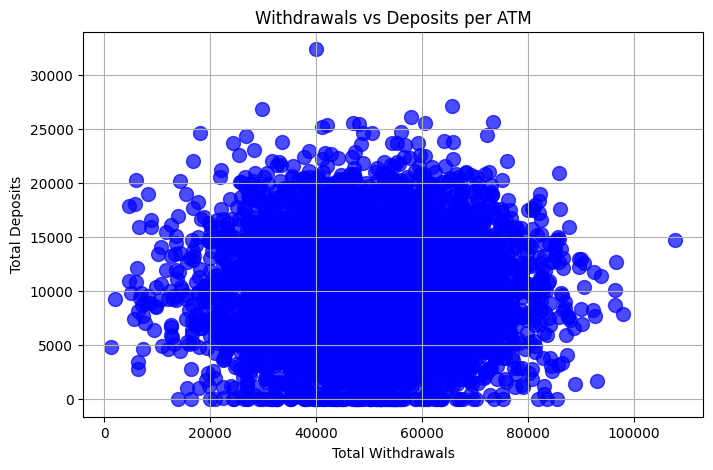

In [5]:
plt.figure(figsize=(8,5))
plt.scatter(df["Total_Withdrawals"], df["Total_Deposits"], c="blue", s=100, alpha=0.7)
plt.xlabel("Total Withdrawals")
plt.ylabel("Total Deposits")
plt.title("Withdrawals vs Deposits per ATM")
plt.grid(True)
plt.show()

In [6]:
#print(df["Weather_Condition"].dropna().unique())
#print(df["Location_Type"].dropna().unique())
df["Time_of_Day"].dropna().unique()
df["ATM_ID"].dropna().unique()

array(['ATM_0041', 'ATM_0007', 'ATM_0014', 'ATM_0029', 'ATM_0028',
       'ATM_0006', 'ATM_0047', 'ATM_0040', 'ATM_0024', 'ATM_0045',
       'ATM_0003', 'ATM_0042', 'ATM_0048', 'ATM_0015', 'ATM_0030',
       'ATM_0020', 'ATM_0050', 'ATM_0031', 'ATM_0035', 'ATM_0034',
       'ATM_0038', 'ATM_0033', 'ATM_0037', 'ATM_0004', 'ATM_0016',
       'ATM_0018', 'ATM_0027', 'ATM_0025', 'ATM_0039', 'ATM_0023',
       'ATM_0046', 'ATM_0017', 'ATM_0001', 'ATM_0036', 'ATM_0002',
       'ATM_0011', 'ATM_0013', 'ATM_0021', 'ATM_0026', 'ATM_0019',
       'ATM_0010', 'ATM_0044', 'ATM_0012', 'ATM_0022', 'ATM_0009',
       'ATM_0032', 'ATM_0008', 'ATM_0049', 'ATM_0005', 'ATM_0043'],
      dtype=object)

## 2. Data Preprocessing

In [7]:
#Ordinal encoding for Day_of_Week 
day_order = {"Monday": 1,"Tuesday": 2,"Wednesday": 3,"Thursday": 4,"Friday": 5,"Saturday": 6,"Sunday": 7}
df["Day_of_Week"] = df["Day_of_Week"].map(day_order)

In [8]:
df.head()

,ATM_ID,Date,Day_of_Week,Time_of_Day,Total_Withdrawals,Total_Deposits,Location_Type,Holiday_Flag,Special_Event_Flag,Previous_Day_Cash_Level,Weather_Condition,Nearby_Competitor_ATMs,Cash_Demand_Next_Day
0,ATM_0041,2022-04-25,1,Morning,57450,9308,Standalone,0,0,112953,Rainy,5,44165
1,ATM_0007,2023-11-24,5,Morning,72845,17896,Supermarket,0,0,115348,Clear,0,41249
2,ATM_0014,2022-08-27,6,Morning,42957,12712,Supermarket,0,0,90731,Cloudy,1,29901
3,ATM_0029,2023-08-27,7,Evening,43014,1375,Mall,0,0,88754,Rainy,5,44155
4,ATM_0028,2022-12-15,4,Evening,36379,2938,Bank Branch,0,0,129312,Snowy,0,29784


In [9]:
df = pd.get_dummies(df, columns=["Weather_Condition", "Location_Type","Time_of_Day"])

In [10]:
df.head()

,ATM_ID,Date,Day_of_Week,Total_Withdrawals,Total_Deposits,Holiday_Flag,Special_Event_Flag,Previous_Day_Cash_Level,Nearby_Competitor_ATMs,Cash_Demand_Next_Day,...,Weather_Condition_Snowy,Location_Type_Bank Branch,Location_Type_Gas Station,Location_Type_Mall,Location_Type_Standalone,Location_Type_Supermarket,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night
0,ATM_0041,2022-04-25,1,57450,9308,0,0,112953,5,44165,...,False,False,False,False,True,False,False,False,True,False
1,ATM_0007,2023-11-24,5,72845,17896,0,0,115348,0,41249,...,False,False,False,False,False,True,False,False,True,False
2,ATM_0014,2022-08-27,6,42957,12712,0,0,90731,1,29901,...,False,False,False,False,False,True,False,False,True,False
3,ATM_0029,2023-08-27,7,43014,1375,0,0,88754,5,44155,...,False,False,False,True,False,False,False,True,False,False
4,ATM_0028,2022-12-15,4,36379,2938,0,0,129312,0,29784,...,True,True,False,False,False,False,False,True,False,False


In [11]:
#extract Date features
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Week_of_Year"] = df["Date"].dt.isocalendar().week

# extract new features from the date 
df["Is_Month_End"] = df["Date"].dt.is_month_end.astype(int)
df["Is_Weekend"] = df["Date"].dt.weekday.isin([5, 6]).astype(int)

# remove the date column
df = df.drop(columns=["Date"])
df.head()

,ATM_ID,Day_of_Week,Total_Withdrawals,Total_Deposits,Holiday_Flag,Special_Event_Flag,Previous_Day_Cash_Level,Nearby_Competitor_ATMs,Cash_Demand_Next_Day,Weather_Condition_Clear,...,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Year,Month,Day,Week_of_Year,Is_Month_End,Is_Weekend
0,ATM_0041,1,57450,9308,0,0,112953,5,44165,False,...,False,False,True,False,2022,4,25,17,0,0
1,ATM_0007,5,72845,17896,0,0,115348,0,41249,True,...,False,False,True,False,2023,11,24,47,0,0
2,ATM_0014,6,42957,12712,0,0,90731,1,29901,False,...,False,False,True,False,2022,8,27,34,0,1
3,ATM_0029,7,43014,1375,0,0,88754,5,44155,False,...,False,True,False,False,2023,8,27,34,0,1
4,ATM_0028,4,36379,2938,0,0,129312,0,29784,False,...,False,True,False,False,2022,12,15,50,0,0


In [12]:
df.head()

,ATM_ID,Day_of_Week,Total_Withdrawals,Total_Deposits,Holiday_Flag,Special_Event_Flag,Previous_Day_Cash_Level,Nearby_Competitor_ATMs,Cash_Demand_Next_Day,Weather_Condition_Clear,...,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Year,Month,Day,Week_of_Year,Is_Month_End,Is_Weekend
0,ATM_0041,1,57450,9308,0,0,112953,5,44165,False,...,False,False,True,False,2022,4,25,17,0,0
1,ATM_0007,5,72845,17896,0,0,115348,0,41249,True,...,False,False,True,False,2023,11,24,47,0,0
2,ATM_0014,6,42957,12712,0,0,90731,1,29901,False,...,False,False,True,False,2022,8,27,34,0,1
3,ATM_0029,7,43014,1375,0,0,88754,5,44155,False,...,False,True,False,False,2023,8,27,34,0,1
4,ATM_0028,4,36379,2938,0,0,129312,0,29784,False,...,False,True,False,False,2022,12,15,50,0,0


In [13]:
df_encoded = df.copy()
target_means = df_encoded.groupby("ATM_ID")["Cash_Demand_Next_Day"].mean()
df_encoded["ATM_ID_TargetEnc"] = df_encoded["ATM_ID"].map(target_means)

In [14]:
df_encoded.head()

,ATM_ID,Day_of_Week,Total_Withdrawals,Total_Deposits,Holiday_Flag,Special_Event_Flag,Previous_Day_Cash_Level,Nearby_Competitor_ATMs,Cash_Demand_Next_Day,Weather_Condition_Clear,...,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Year,Month,Day,Week_of_Year,Is_Month_End,Is_Weekend,ATM_ID_TargetEnc
0,ATM_0041,1,57450,9308,0,0,112953,5,44165,False,...,False,True,False,2022,4,25,17,0,0,43193.000000
1,ATM_0007,5,72845,17896,0,0,115348,0,41249,True,...,False,True,False,2023,11,24,47,0,0,41666.968000
2,ATM_0014,6,42957,12712,0,0,90731,1,29901,False,...,False,True,False,2022,8,27,34,0,1,43190.242424
3,ATM_0029,7,43014,1375,0,0,88754,5,44155,False,...,True,False,False,2023,8,27,34,0,1,43532.775510
4,ATM_0028,4,36379,2938,0,0,129312,0,29784,False,...,True,False,False,2022,12,15,50,0,0,42078.532787


In [15]:
df= df.drop(columns=["ATM_ID"])

In [16]:
df.head()

,Day_of_Week,Total_Withdrawals,Total_Deposits,Holiday_Flag,Special_Event_Flag,Previous_Day_Cash_Level,Nearby_Competitor_ATMs,Cash_Demand_Next_Day,Weather_Condition_Clear,Weather_Condition_Cloudy,...,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Year,Month,Day,Week_of_Year,Is_Month_End,Is_Weekend
0,1,57450,9308,0,0,112953,5,44165,False,False,...,False,False,True,False,2022,4,25,17,0,0
1,5,72845,17896,0,0,115348,0,41249,True,False,...,False,False,True,False,2023,11,24,47,0,0
2,6,42957,12712,0,0,90731,1,29901,False,True,...,False,False,True,False,2022,8,27,34,0,1
3,7,43014,1375,0,0,88754,5,44155,False,False,...,False,True,False,False,2023,8,27,34,0,1
4,4,36379,2938,0,0,129312,0,29784,False,False,...,False,True,False,False,2022,12,15,50,0,0


# Modeling and evaluation 

In [17]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


In [18]:
# first we will stat with tree based algo (Xgboost,LightGBM,RandomForest)

# Prepare the data
X = df.drop(['Cash_Demand_Next_Day'], axis=1)
y = df['Cash_Demand_Next_Day']

# Initialize models
models = {
    'XGBoost': XGBRegressor(n_estimators=500, random_state=42,learning_rate=0.1,max_depth=6,subsample=0.8),
    'LightGBM': LGBMRegressor( verbosity=-1,n_estimators= 515, random_state=42,learning_rate=0.021866499274203838,num_leaves=18,feature_fraction=0.7691465913820418,subsample=0.6492379053645982),
    'RandomForest': RandomForestRegressor(n_estimators=319, random_state=42,max_depth=14,min_samples_split=4,min_samples_leaf=1,max_features= None)
}

#Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)
results = {}

print("Training and evaluating models...")
print("=" * 60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    mae_scores = []
    rmse_scores = []
    r2_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        # Get training and validation data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train model (no scaling needed for tree-based algorithms)
        model.fit(X_train, y_train)
        
        # Make predictions
        pred = model.predict(X_val)
        
        # Calculate metrics
        mae = mean_absolute_error(y_val, pred)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        r2 = r2_score(y_val, pred)
        
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        
        print(f"  Fold {fold+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
    # Store average results
    results[name] = {
        'MAE': np.mean(mae_scores),
        'MAE_std': np.std(mae_scores),
        'RMSE': np.mean(rmse_scores),
        'RMSE_std': np.std(rmse_scores),
        'R2': np.mean(r2_scores),
        'R2_std': np.std(r2_scores)
    }

Training and evaluating models...

Training XGBoost...
  Fold 1: MAE=5800.88, RMSE=7276.89, R²=0.819
  Fold 2: MAE=5562.90, RMSE=6858.76, R²=0.822
  Fold 3: MAE=5785.12, RMSE=7262.99, R²=0.824
  Fold 4: MAE=5296.30, RMSE=6639.48, R²=0.842
  Fold 5: MAE=5417.29, RMSE=6752.43, R²=0.820

Training LightGBM...
  Fold 1: MAE=5535.81, RMSE=6902.88, R²=0.837
  Fold 2: MAE=5320.19, RMSE=6455.82, R²=0.842
  Fold 3: MAE=5422.34, RMSE=6638.16, R²=0.853
  Fold 4: MAE=5029.73, RMSE=6161.16, R²=0.864
  Fold 5: MAE=5294.47, RMSE=6415.72, R²=0.838

Training RandomForest...
  Fold 1: MAE=5481.14, RMSE=6814.40, R²=0.841
  Fold 2: MAE=5374.96, RMSE=6588.18, R²=0.836
  Fold 3: MAE=5532.41, RMSE=6828.89, R²=0.845
  Fold 4: MAE=5160.41, RMSE=6300.65, R²=0.858
  Fold 5: MAE=5259.07, RMSE=6363.77, R²=0.840


In [19]:
# Sort by MAE (lower is better)
sorted_results = sorted(results.items(), key=lambda x: x[1]['MAE'])

print(f"{'Model':<17} {'MAE':<17} {'RMSE':<17} {'R²':<12}")
print("-" * 62)
+++9
for name, metrics in sorted_results:
    mae = metrics['MAE']
    mae_std = metrics['MAE_std']
    rmse = metrics['RMSE']
    rmse_std = metrics['RMSE_std']
    r2 = metrics['R2']
    r2_std = metrics['R2_std']
    
    print(f"{name:<12} {mae:.2f}±{mae_std:.2f}    {rmse:.2f}±{rmse_std:.2f}    {r2:.3f}±{r2_std:.3f}")

Model             MAE               RMSE              R²          
--------------------------------------------------------------
LightGBM     5320.51±168.50    6514.75±246.65    0.847±0.010
RandomForest 5361.60±137.58    6579.18±219.88    0.844±0.007
XGBoost      5572.50±198.91    6958.11±263.92    0.825±0.008


* **Chosen Model:** LightGBM showed the best performance with the lowest MAE/RMSE and highest R², making it the most accurate and reliable model for our forecasting task.